# Generating enclosures (proof of a concept)

Algorithm to generate enclosed tessellation starts form the _enclosures_, continuous area of land enclosed form all sides by a barrier. In our case, barriers are roads, railways, rivers and a coastline. Although the algorithm itself can generate enclosures, it may be inefficient for large heterogenous GeoDataFrames. The criticial bottleneck is the `union` of all geometries before polygonizing them. That can be very expensive if the input data are not topologically clean. In the case of our barriers, they are non-topological by definition. To overcome this issue, we use two-step parallelized algorithm, which should in the end result in the same enclosures.

In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

## Load data

In [2]:
x, y = 352125.32, 492802.86  # coordinates in epsg 27700
buffer = 5000  # radius in [m]

In [3]:
sql = f'SELECT * FROM openroads_200803_topological WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

roads = gpd.read_postgis(sql, engine, geom_col='geometry')

In [4]:
sql = f'SELECT * FROM openrivers_200909 WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'

rivers = gpd.read_postgis(sql, engine, geom_col='geometry')

In [5]:
sql = f'SELECT * FROM openmap_railwaytrack_200824 WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'

railway = gpd.read_postgis(sql, engine, geom_col='geometry')

<AxesSubplot:>

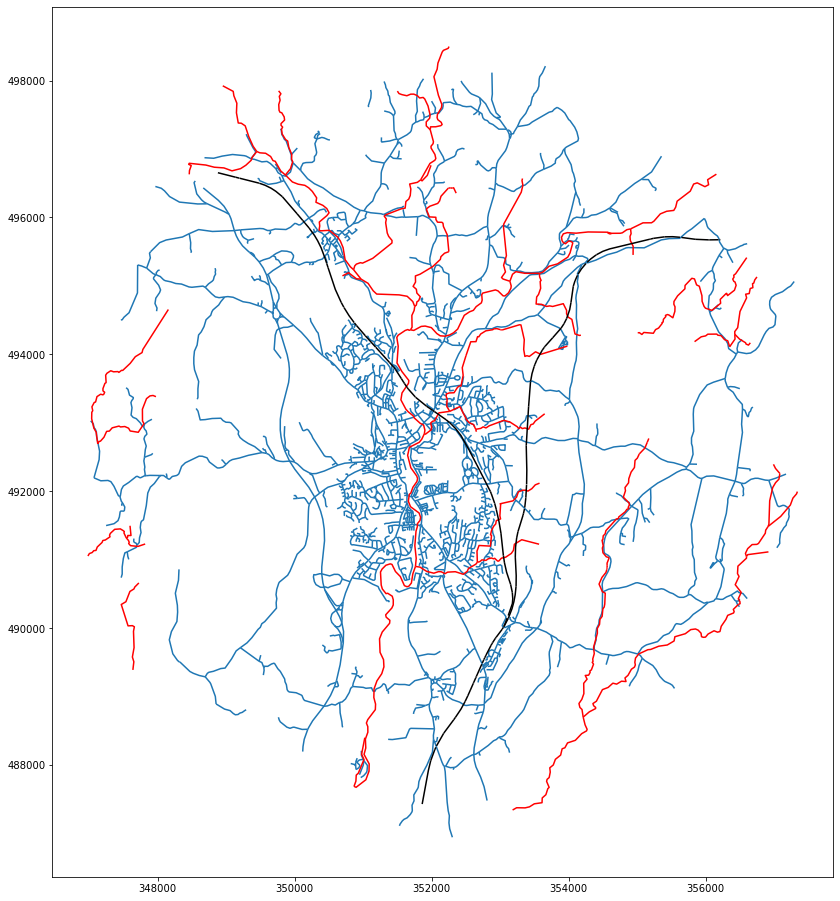

In [6]:
ax = roads.plot(figsize=(16, 16))
rivers.plot(ax=ax, color='r')
railway.plot(ax=ax, color='k')

## Snap railways to close the gaps

Railway network has gaps where it crosses roads, mostly because railway in those cases in under the bridge. These gaps cause issues during polygonization, as we need each enclosure to be fully closed. To overcome the issue, two preprocessing steps are introduced:

1. extend lines to road network to close the gap
2. snap railways to itself to ensure continuity of LineStrings

Rail network, even extended one, does not enclose area as we would need. Probably due to the floating point error, its conection to road network is sometimes (most of the times to be precise) seen as a gap. We have to preprocess railways further to snap segments to each other and generate contiguous topologically correct geometries.

In [7]:
from snap import line_to_line
from consolidate import topology
import pygeos

In [8]:
%%time
extended = line_to_line(railway, roads, 50)

CPU times: user 61 ms, sys: 420 µs, total: 61.4 ms
Wall time: 59.5 ms


In [9]:
%%time
extended_topo = topology(extended)

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 21.4 ms


In [10]:
%%time
snapped = pygeos.snap(extended_topo.geometry.values.data, pygeos.union_all(extended_topo.geometry.values.data), 20)

CPU times: user 2.58 ms, sys: 0 ns, total: 2.58 ms
Wall time: 2.59 ms


In [11]:
%%time
rail_topo = topology(gpd.GeoDataFrame(geometry=snapped))

CPU times: user 19.6 ms, sys: 3.61 ms, total: 23.2 ms
Wall time: 20.2 ms


In [12]:
len(rail_topo), len(extended_topo)

(10, 22)

## Generate enclosures

### First level

We first generate enclosures defined by the external boundary of case study area and road network as a simple `polygonize` of combined geometries. That should be relatively cheap as there are almost no non-topological intersections between the layers.

In [13]:
from shapely.ops import polygonize
from shapely.geometry import Point
import pandas as pd

In [14]:
# get road-based polygons
limit = Point(x, y).buffer(buffer)

In [15]:
%%time
barriers = pd.concat([roads.geometry, gpd.GeoSeries([limit.boundary])])

CPU times: user 1.88 ms, sys: 0 ns, total: 1.88 ms
Wall time: 1.6 ms


In [16]:
%%time
unioned = barriers.unary_union

CPU times: user 57.6 ms, sys: 749 µs, total: 58.4 ms
Wall time: 56.7 ms


In [17]:
%%time
polygons = polygonize(unioned)
enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

CPU times: user 56.7 ms, sys: 14.8 ms, total: 71.5 ms
Wall time: 51.8 ms


<AxesSubplot:>

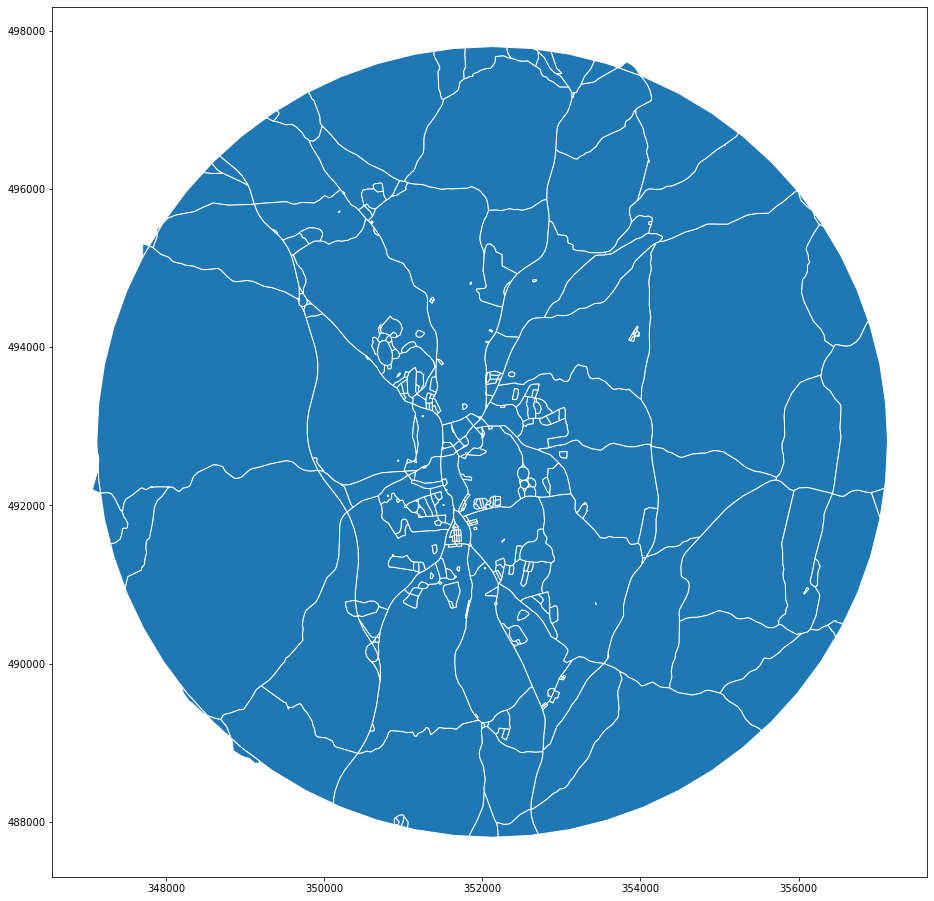

In [18]:
gpd.GeoSeries(enclosures).plot(figsize=(16, 16), edgecolor='w')

### Additional barriers

In the second step we loop through the road-based enclosures and check if that intersects any other barrier. If it does, we remove the original geometry and generate new one based on polygonization of goemetries of all barrier layers combined. This step might be a bit more expensive, but the loop can be parallelized and we are always working with a small set of geometries only.

In [19]:
additional = pd.concat([rivers.geometry, rail_topo.geometry])

In [20]:
add_sindex = additional.sindex

In [21]:
import numpy as np
from geopandas._vectorized import _pygeos_to_shapely

In [22]:
%%time
drop = []
new = []
for i, poly in enumerate(enclosures.data):
    crossing = add_sindex.query(poly, predicate='intersects')
    if crossing.size > 0:
        drop.append(i)
        union = pygeos.union_all(np.append(additional.values.data[crossing], pygeos.boundary(poly)))
        polygons = polygonize(_pygeos_to_shapely(union))
        new += list(polygons)

CPU times: user 60.2 ms, sys: 3.8 ms, total: 63.9 ms
Wall time: 61.1 ms


In [23]:
%%time
final_enclosures = gpd.GeoSeries(enclosures).drop(drop).append(gpd.GeoSeries(new))

CPU times: user 4.55 ms, sys: 273 µs, total: 4.83 ms
Wall time: 4.28 ms


<AxesSubplot:>

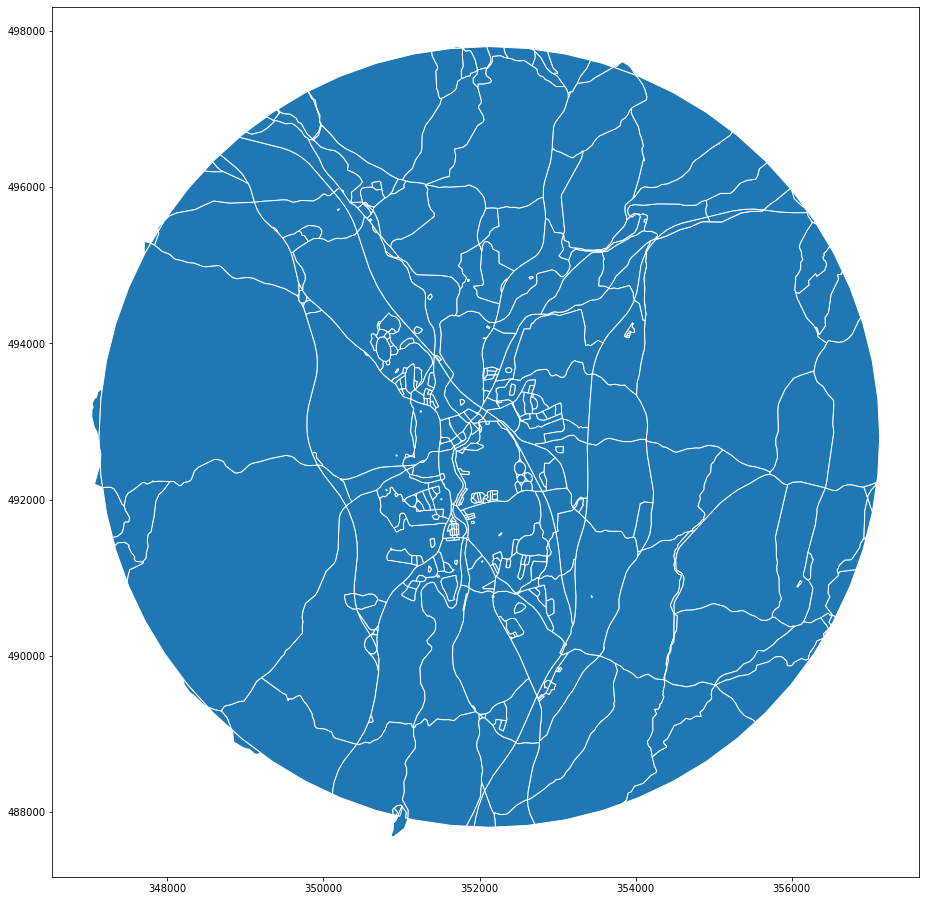

In [24]:
final_enclosures.plot(figsize=(16, 16), edgecolor='w')

Let's compare the first level enclosures with the final ones. Red lines marks additional divisions.

<AxesSubplot:>

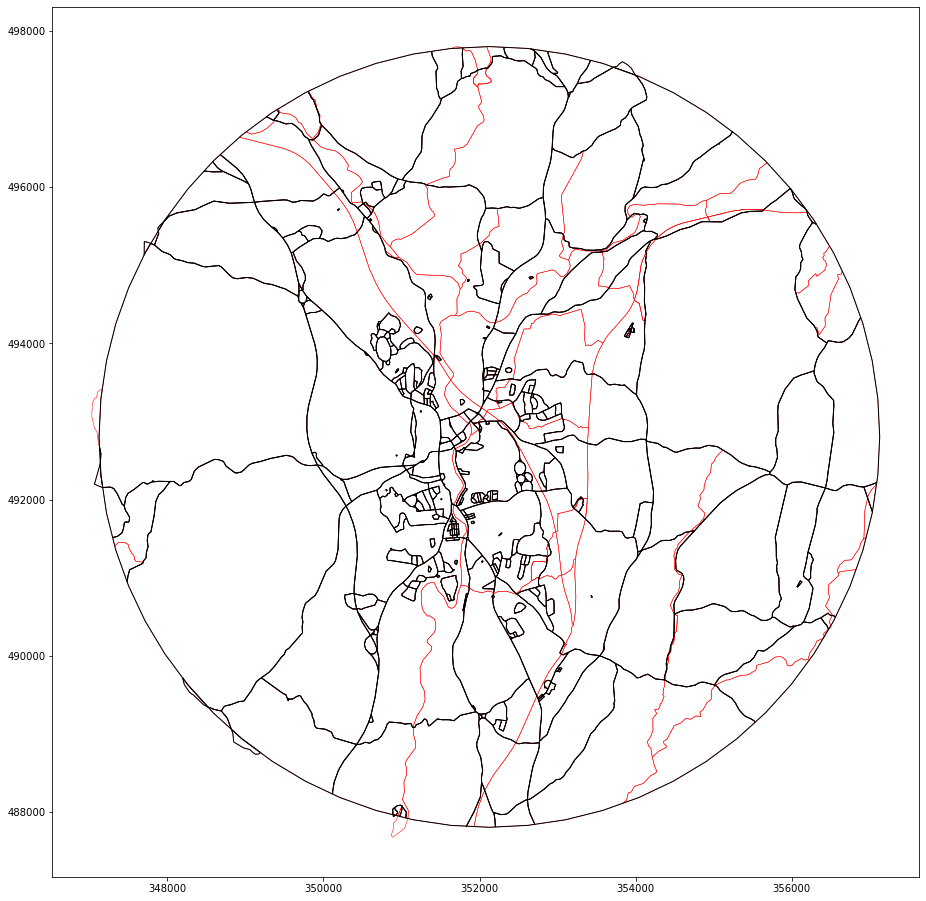

In [33]:
ax = gpd.GeoSeries(enclosures).plot(figsize=(16, 16), edgecolor='k', facecolor='none', zorder=1)
final_enclosures.plot(ax=ax, edgecolor='r', facecolor='none', linewidth=.5, zorder=0)

We can further check how many polygons are removed and how many new are introduce, compared to the original count.

In [25]:
len(drop), len(new), len(enclosures), len(final_enclosures)

(63, 227, 378, 542)

## Parallel version using dask

The core of the method is the loop above. That can be easily parallelized using `dask`.

In [118]:
import dask.bag as db
from dask.distributed import Client
import itertools

We use a only local cluster for now.

In [119]:
client = Client()
client

<Client: 'tcp://127.0.0.1:43989' processes=7 threads=28, memory=84.28 GB>

To further vectorize our operations, we use `sindex.query_bulk` instead of querying within each iteration of the loop.

In [120]:
%%time
inp, res = gpd.GeoSeries(enclosures).sindex.query_bulk(additional.geometry, predicate='intersects')

CPU times: user 5.67 ms, sys: 0 ns, total: 5.67 ms
Wall time: 5.4 ms


We are interested only in enclosures which interect any other barrier (i.e. are present in `res`) and only once (i.e. unique values).

In [121]:
%%time
unique = np.unique(res)

CPU times: user 117 µs, sys: 15 µs, total: 132 µs
Wall time: 101 µs


The array of indices of unique polygons which need further subdivision is then converted into `dask.bag`.

In [122]:
bag = db.from_sequence(unique)

In [123]:
def divide(i):
    """Subdivide polygon `i` based on additional barriers.
    """
    poly = enclosures.data[i]
    crossing = inp[res==i]
    union = pygeos.union_all(np.append(additional.values.data[crossing], pygeos.boundary(poly)))
    polygons = polygonize(_pygeos_to_shapely(union))
    return list(polygons)

In [124]:
%%time
new = bag.map(divide).compute()

CPU times: user 658 ms, sys: 21.7 ms, total: 680 ms
Wall time: 1.27 s


In [125]:
%%time
final_enclosures = gpd.GeoSeries(enclosures).drop(drop).append(gpd.GeoSeries(list(itertools.chain.from_iterable(new))))

CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 4.04 ms


<AxesSubplot:>

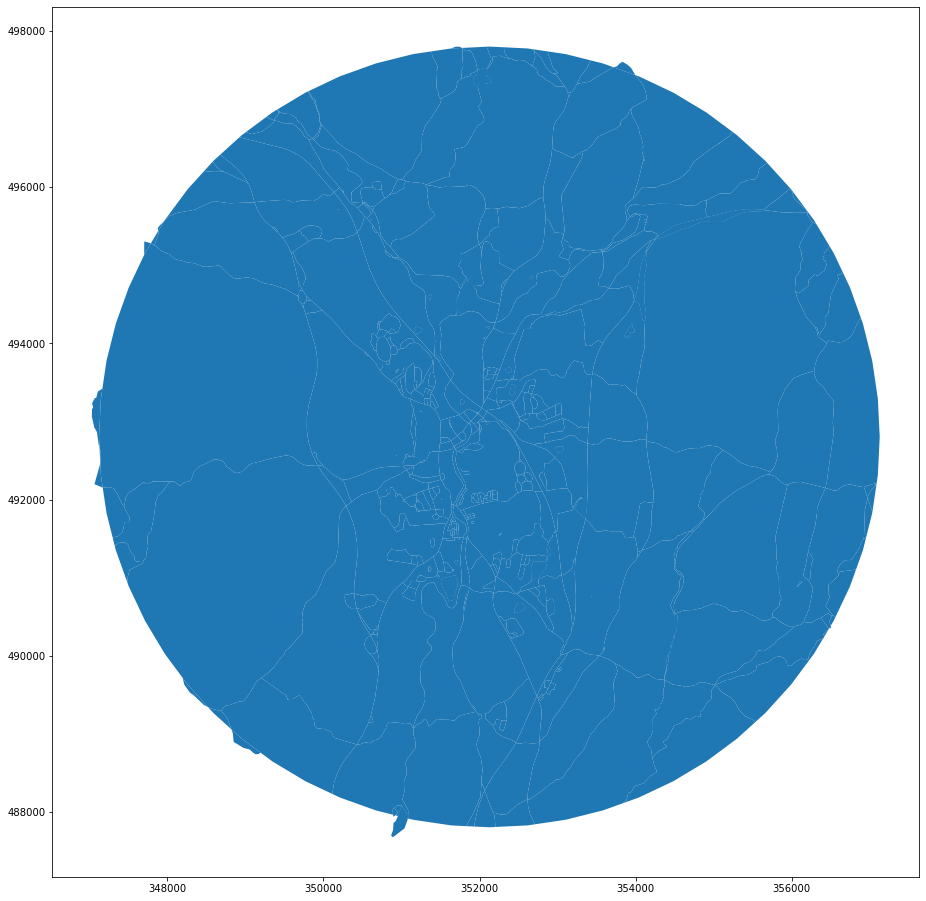

In [126]:
final_enclosures.plot(figsize=(16, 16))

In [127]:
client.close()

## Further details

See below the examples of generating enclosures based on individual layers without any pre-processing. This is the reason why we snap railways.

In [2]:
x, y = 334289.32, 390468.43  # coordinates in epsg 27700
buffer = 5000  # radius in [m]

sql = f'SELECT * FROM openroads_200803_topological WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'
roads = gpd.read_postgis(sql, engine, geom_col='geometry')

sql = f'SELECT * FROM openrivers_200909 WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'
rivers = gpd.read_postgis(sql, engine, geom_col='geometry')

sql = f'SELECT * FROM openroads_200803_topological WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'
roads = gpd.read_postgis(sql, engine, geom_col='geometry')

sql = f'SELECT * FROM openmap_railwaytrack_200824 WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'
railway = gpd.read_postgis(sql, engine, geom_col='geometry')

In [5]:
import contextily as ctx
from mapclassify import greedy

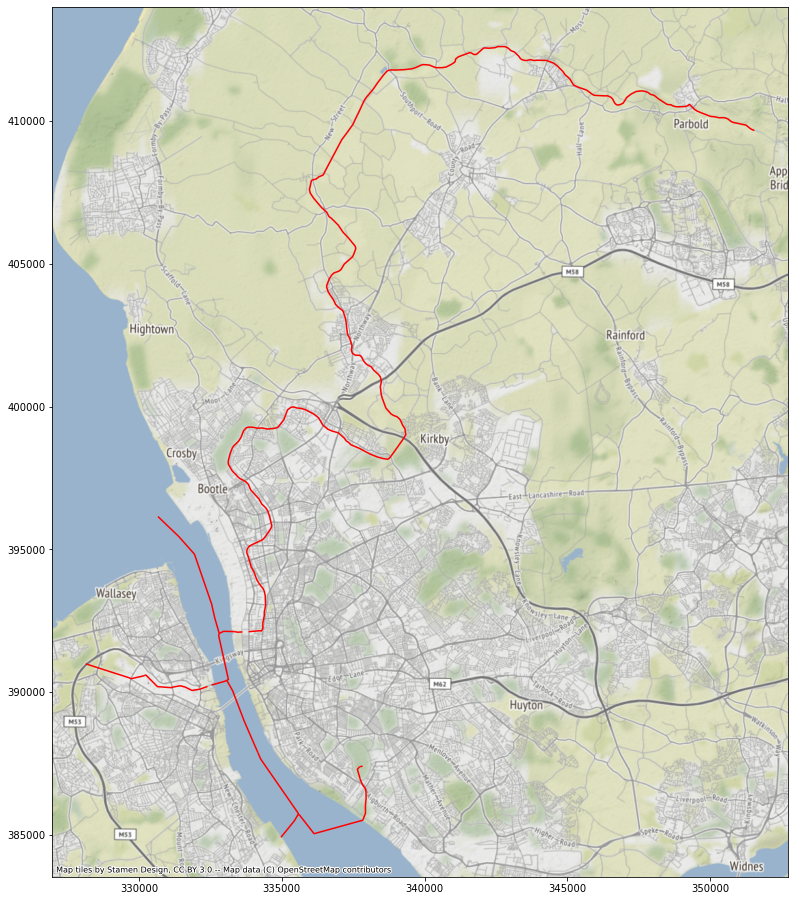

In [4]:
ax = rivers.plot(color='r', figsize=(16, 16))
ctx.add_basemap(ax, crs=rivers.crs)

Notice the two gaps just before the rivers reach the main water body (Mersey). That is an issue, but there are only a few gaps compared to the whole network, hence it is unlikely that they would have any significant effect on the results.

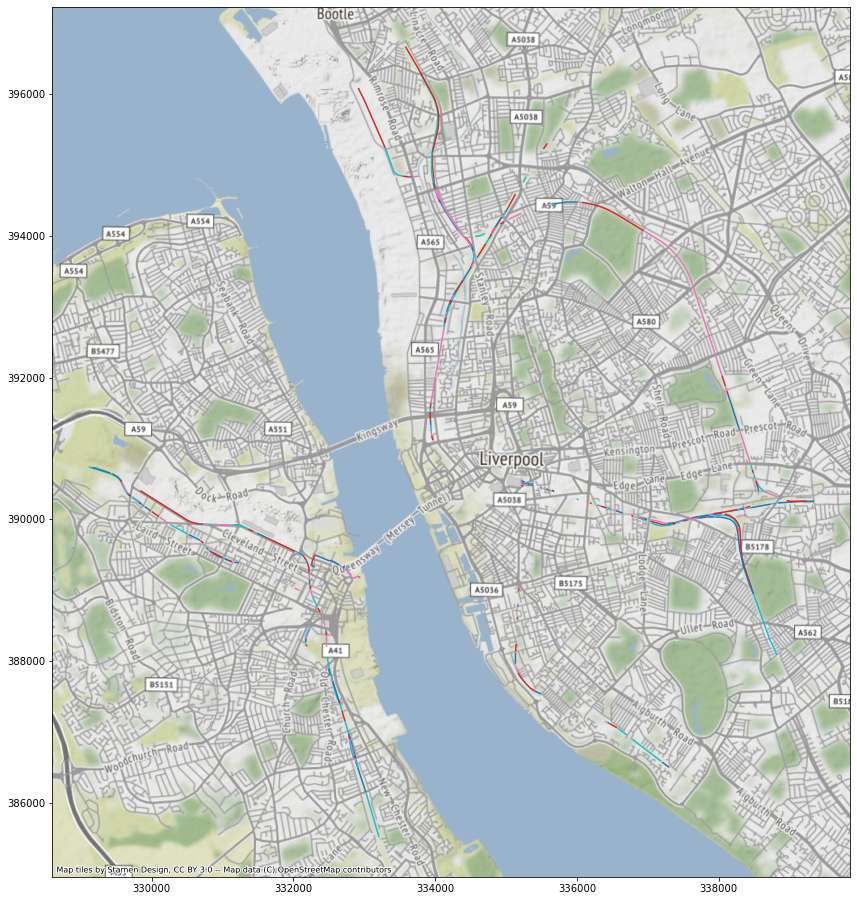

In [6]:
ax = railway.plot(greedy(railway), categorical=True, figsize=(16, 16))
ctx.add_basemap(ax, crs=railway.crs)

Railway is disconnected and introduces nodes where none actually are, at least in terms of barriers.

In [9]:
%%time
extended = line_to_line(railway, roads, 50)

CPU times: user 788 ms, sys: 53.1 ms, total: 841 ms
Wall time: 1.02 s


See how enclosures look if we use roads only.

In [13]:
limit = Point(x, y).buffer(buffer)
polygons = polygonize(
    roads.geometry.append(gpd.GeoSeries([limit.boundary])).unary_union
)
road_enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

<AxesSubplot:>

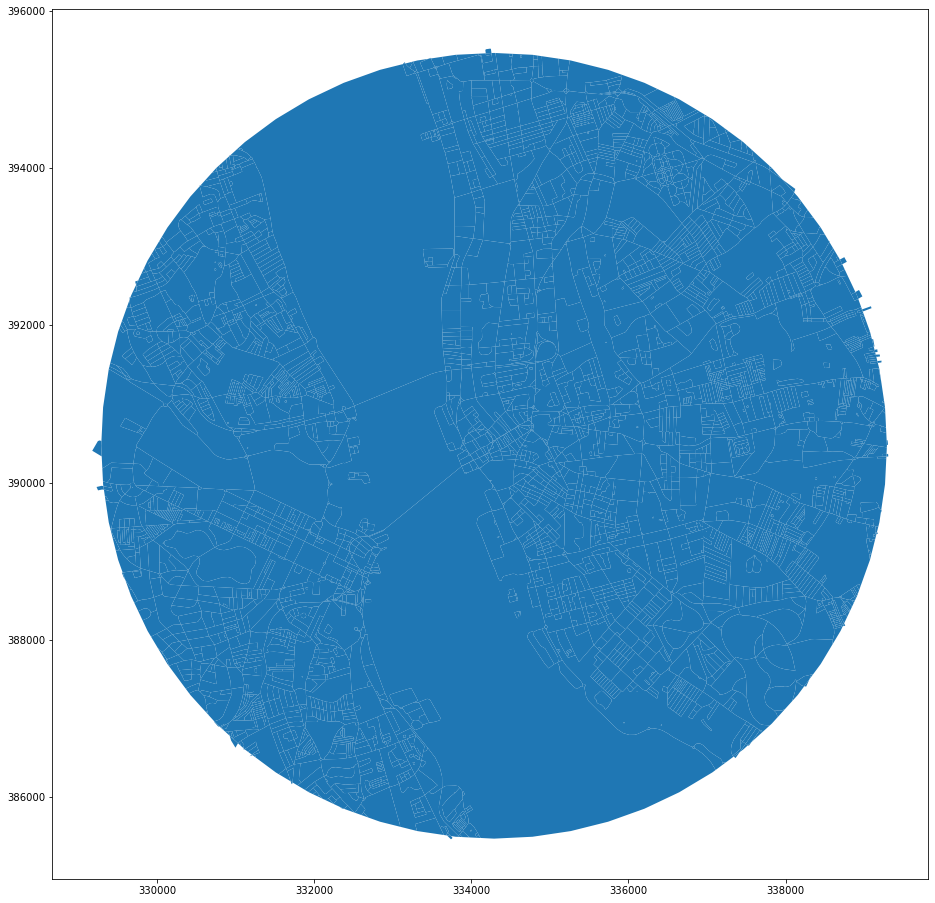

In [14]:
gpd.GeoSeries(road_enclosures).plot(figsize=(16, 16))

Doing the same for railways only results in the single polygon. In the current state, railway does not work as a boundary.

In [15]:
polygons = polygonize(
    extended.geometry.append(gpd.GeoSeries([limit.boundary])).unary_union
)
rail_enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

<AxesSubplot:>

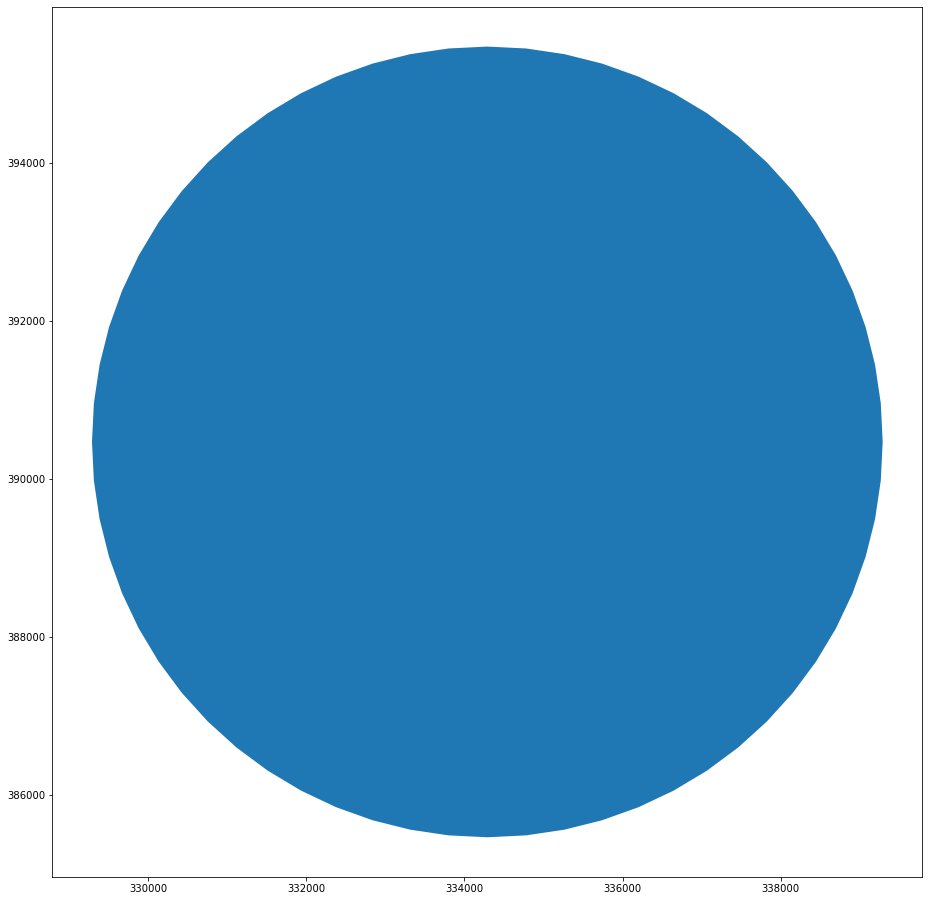

In [16]:
gpd.GeoSeries(rail_enclosures).plot(figsize=(16, 16))

In the case of rivers, we face the issue with gaps.

<AxesSubplot:>

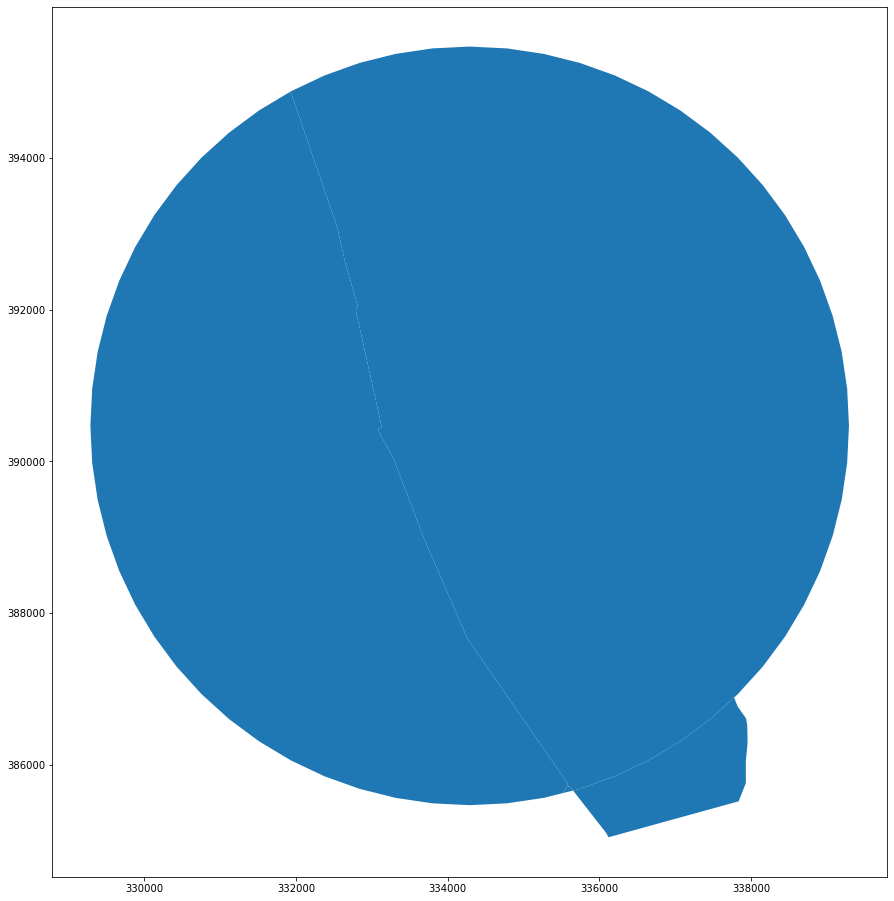

In [17]:
polygons = polygonize(
    rivers.geometry.append(gpd.GeoSeries([limit.boundary])).unary_union
)
rivers_enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

gpd.GeoSeries(rivers_enclosures).plot(figsize=(16, 16))